In [74]:
from pycirclize import Circos
from pycirclize.parser import Gff
import matplotlib as mpl
from Bio import SeqIO
import numpy as np
from pycirclize.parser import Genbank
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [ ]:
gff_file = "prokka_outPb01/Pb01_wolb.gff"
gff = Gff(gff_file)
gbk_file = "prokka_outPb01/Pb01_wolb.gbk"
gbk = Genbank(gbk_file)

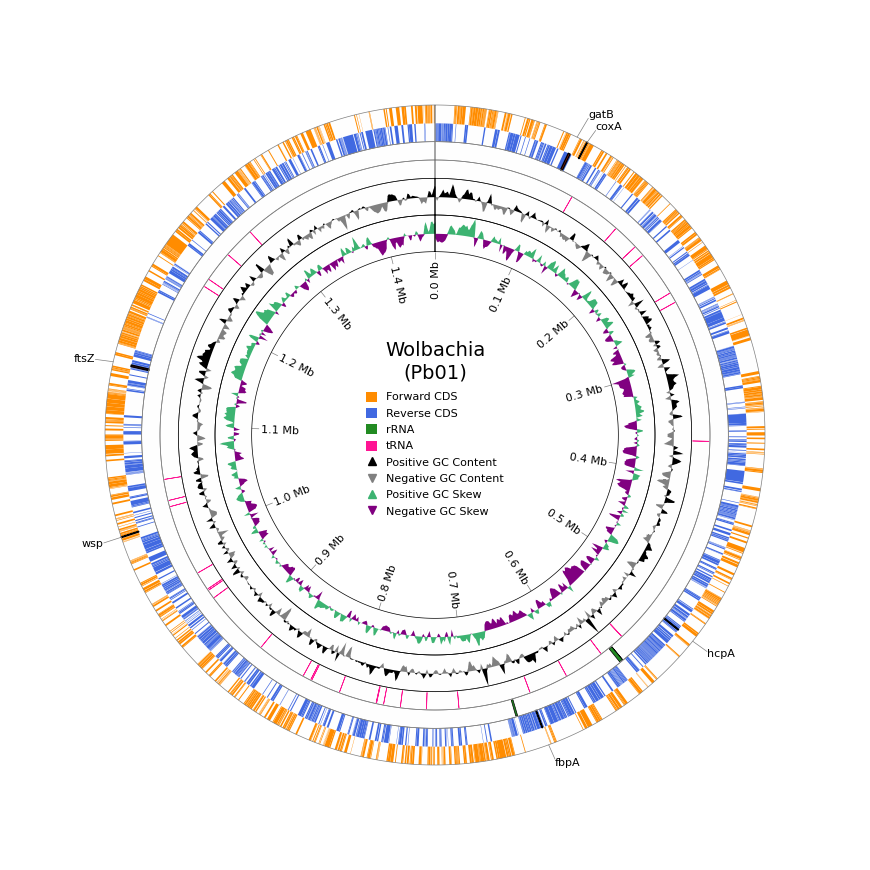

In [ ]:
seqid2size = gff.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Wolbachia\n(Pb01)", size=14, r=20)

custom_loci = [
    {
        'seqid': 'Pb01',
        'start': 110893,
        'end': 111294,
        'label': 'coxA',
        'color': 'blue',
        'strand': 1,  # Forward strand
    },
    {
        'seqid': 'Pb01',
        'start': 646193,
        'end': 646621,
        'label': 'fbpA',
        'color': 'firebrick',
        'strand': -1,  # Reverse strand
    },
    {
        'seqid': 'Pb01',
        'start': 102430,
        'end': 103851,
        'label': 'gatB',
        'color': 'firebrick',
        'strand': -1,  # Reverse strand
    },
    {
        'seqid': 'Pb01',
        'start': 520077,
        'end': 520520,
        'label': 'hcpA',
        'color': 'firebrick',
        'strand': -1,  # Reverse strand
    },
    {
        'seqid': 'Pb01',
        'start': 1143103,
        'end': 1144287,
        'label': 'ftsZ',
        'color': 'firebrick',
        'strand': -1,  # Reverse strand
    },
    {
        'seqid': 'Pb01',
        'start': 1018578,
        'end': 1019042,
        'label': 'wsp',
        'color': 'blue',
        'strand': 1,  # Forward strand
    }
]

seqid2features = gff.get_seqid2features(feature_type=None)
seqid2seq = gbk.get_seqid2seq()
for sector in circos.sectors:    
    cds_track = sector.add_track((80, 90), r_pad_ratio=0.1)
    cds_track.axis(fc="#FEFEFE", ec="grey")
    rrna_track = sector.add_track((75, 80), r_pad_ratio=0.1)
    rrna_track.axis(fc="#FEFEFE", ec="grey")
    trna_track = sector.add_track((70, 75), r_pad_ratio=0.1)
    trna_track.axis(fc="#FEFEFE", ec="grey")

    features = seqid2features[sector.name]
    label_pos_list, labels = [], []
    for feature in features:
        if feature.type == "CDS" and feature.location.strand == 1:
            cds_track.genomic_features(feature, fc="darkorange", r_lim=(85, 90))
        elif feature.type == "CDS" and feature.location.strand == -1:
            cds_track.genomic_features(feature, fc="royalblue", r_lim=(80, 85))
        elif feature.type == "rRNA":
            rrna_track.genomic_features(feature, fc="forestgreen", lw=0.5)
        elif feature.type == "tRNA":
            trna_track.genomic_features(feature, color="deeppink", lw=0.5)
    
    # Add custom loci
    for loci in custom_loci:
        if loci['seqid'] == sector.name:
            start = loci['start']
            end = loci['end']
            label = loci['label']
            color = loci['color']
            strand = loci.get('strand', 1)  # Default to forward strand
            
            # Determine r_lim based on strand
            r_lim = (85, 90) if strand == 1 else (80, 85)
            
            from Bio.SeqFeature import SeqFeature, FeatureLocation
            feature = SeqFeature(
                FeatureLocation(start, end, strand),
                type="CDS"
            )
            
            
            cds_track.genomic_features(feature, r_lim=r_lim, fc=color, lw=1)
            
            position = (start + end) / 2
            cds_track.annotate(position, label, label_size=8)

##########################################################################
    # Create GC content track

    gc_content_track = sector.add_track((60, 70))
    gc_content_track.axis(fc="#FEFEFE")

    seq = seqid2seq[sector.name]
    label_pos_list, gc_contents = gbk.calc_gc_content(seq=seq)

    gc_contents = gc_contents - gbk.calc_genome_gc_content(seq=gbk.full_genome_seq)
    positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
    negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
    abs_max_gc_content = np.max(np.abs(gc_contents))
    vmin, vmax = -abs_max_gc_content, abs_max_gc_content
    gc_content_track.fill_between(
        label_pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
    )
    gc_content_track.fill_between(
        label_pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
    )
    
##########################################################################
    # Plot GC skew
    gc_skew_track = sector.add_track((50, 60))
    gc_skew_track.axis(fc="#FEFEFE")

    label_pos_list, gc_skews = gbk.calc_gc_skew(seq=seq)
    positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
    negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
    abs_max_gc_skew = np.max(np.abs(gc_skews))
    vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
    gc_skew_track.fill_between(
        label_pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="mediumseagreen"
    )
    gc_skew_track.fill_between(
        label_pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="purple"
    )

    # Plot xticks & intervals on inner position
    gc_skew_track.xticks_by_interval(
        interval=100000,
        outer=False,
        label_formatter=lambda v: f"{v/ 1000000:.1f} Mb",
        label_orientation="vertical",
        line_kws=dict(ec="grey", lw=0.5),
    )

##########################################################################

fig = circos.plotfig()
# Add legend
handles = [
    Patch(color="darkorange", label="Forward CDS"),
    Patch(color="royalblue", label="Reverse CDS"),
    Patch(color="forestgreen", label="rRNA"),
    Patch(color="deeppink", label="tRNA"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None"),
    Line2D([], [], color="mediumseagreen", label="Positive GC Skew", marker="^", ms=6, ls="None"),
    Line2D([], [], color="purple", label="Negative GC Skew", marker="v", ms=6, ls="None"),
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)
# savefig as svg and remove text formatting
mpl.rcParams['svg.fonttype'] = 'none'
fig.savefig("wolbachia_circos.svg", format="svg", bbox_inches="tight")